In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

import visulization as vs


from plotly.offline import init_notebook_mode, iplot
from elephas.utils.rdd_utils import to_simple_rdd

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, FloatType
from pyspark.sql.functions import col

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler,MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression , GBTClassifier, RandomForestClassifier, LinearSVC, MultilayerPerceptronClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from sklearn import preprocessing
import time

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame
from tensorflow.keras import optimizers


seed = 23
random.seed = seed
init_notebook_mode(connected=True) ## plotly init

<h1>set ups Section</h1>

In [2]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '32G').set('spark.driver.memory', '32G').set('spark.driver.maxResultSize', '32G').setAppName('Elephas_App')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [3]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

<h1>Reading Data</h1>

In [4]:
EEG_data_train = spark.read.load('./TRAIN/Train', 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

In [5]:
EEG_data_test = spark.read.load('./TEST/Test', 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

In [6]:
EEG_data = EEG_data_train.unionByName(EEG_data_test)

<h1>grasps on Data<h1>

In [7]:
EEG_data.show(5)

+---+------------+---------------+----------+------------+------------------+------------------+-------+-----------+----------+
|_c0|trial number|sensor position|sample num|sensor value|subject identifier|matching condition|channel|       name|      time|
+---+------------+---------------+----------+------------+------------------+------------------+-------+-----------+----------+
|  5|          13|            FP1|         0|       2.686|                 a|       S2 nomatch,|      0|co2a0000375|       0.0|
|  6|          13|            FP1|         1|      -0.244|                 a|       S2 nomatch,|      0|co2a0000375|0.00390625|
|  7|          13|            FP1|         2|       -4.15|                 a|       S2 nomatch,|      0|co2a0000375| 0.0078125|
|  8|          13|            FP1|         3|      -7.568|                 a|       S2 nomatch,|      0|co2a0000375|0.01171875|
|  9|          13|            FP1|         4|      -9.521|                 a|       S2 nomatch,|      0|

In [8]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(EEG_data.count(), len(EEG_data.columns)))

The shape of the dataset is 15532032 rows by 10 columns


In [9]:
print(EEG_data.columns)
EEG_data.printSchema()

['_c0', 'trial number', 'sensor position', 'sample num', 'sensor value', 'subject identifier', 'matching condition', 'channel', 'name', 'time']
root
 |-- _c0: integer (nullable = true)
 |-- trial number: integer (nullable = true)
 |-- sensor position: string (nullable = true)
 |-- sample num: integer (nullable = true)
 |-- sensor value: double (nullable = true)
 |-- subject identifier: string (nullable = true)
 |-- matching condition: string (nullable = true)
 |-- channel: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- time: double (nullable = true)



<h1>Data Initial Preprocessing<h1>

In [7]:
## replace some 'sensor position' values
EEG_data = EEG_data.withColumn("sensor position", when(EEG_data['sensor position'] == 'AF1',"AF3") \
      .when(EEG_data['sensor position'] == 'AF2',"AF4") \
      .when(EEG_data['sensor position'] == 'PO1',"PO3") \
      .when(EEG_data['sensor position'] == 'PO2',"PO4") \
      .otherwise(EEG_data['sensor position']))
##replace the comma in matchas
EEG_data = EEG_data.withColumn("matching condition", when(EEG_data["matching condition"]== 'S2 nomatch,','S2 nomatch')\
           .otherwise(EEG_data["matching condition"]))

In [8]:
## remove rows with undefined positions
EEG_data = EEG_data.where(~EEG_data['sensor position'].contains('X') & ~EEG_data['sensor position'].contains('Y') & ~EEG_data['sensor position'].contains('nd'))

In [9]:
#drop duplicated rows
EEG_data = EEG_data.dropDuplicates()
print("Distinct count: "+str(EEG_data.count()))
EEG_data.show(5)

Distinct count: 14429184
+---+------------+---------------+----------+------------+------------------+------------------+-------+-----------+----------+
|_c0|trial number|sensor position|sample num|sensor value|subject identifier|matching condition|channel|       name|      time|
+---+------------+---------------+----------+------------+------------------+------------------+-------+-----------+----------+
|132|          13|            FP1|       127|     -20.752|                 a|        S2 nomatch|      0|co2a0000375|0.49609375|
|194|          13|            FP1|       189|       3.174|                 a|        S2 nomatch|      0|co2a0000375|0.73828125|
|243|          13|            FP1|       238|      18.799|                 a|        S2 nomatch|      0|co2a0000375| 0.9296875|
|556|          13|             F7|        37|      -8.982|                 a|        S2 nomatch|      2|co2a0000375|0.14453125|
|772|          13|             F7|       253|       8.108|                 a|  

In [51]:
new = EEG_data.toPandas()

In [60]:
transposed_df_list = []

for group_df in tqdm(new.groupby(['name', 'trial number', 'matching condition', 'channel', 'subject identifier'])): 
    _df = pd.DataFrame(group_df[1]['sensor value']).T
    _df.columns = [f'sample_{idx}' for idx in range(256)]
    _df['name'] = group_df[0][0]
    _df['trial number'] = group_df[0][1]
    _df['matching condition'] = group_df[0][2]
    _df['channel'] = group_df[0][3]
    _df['subject identifier'] = group_df[0][4]
    
    transposed_df_list.append(_df)
    
df = pd.concat(transposed_df_list)
df = df[[*df.columns[-5:],*df.columns[0:-5]]]
df = df.reset_index(drop=True)
df.head(3)

100%|██████████| 56364/56364 [01:11<00:00, 785.73it/s]


,name,trial number,matching condition,channel,subject identifier,sample_0,sample_1,sample_2,sample_3,sample_4,...,sample_246,sample_247,sample_248,sample_249,sample_250,sample_251,sample_252,sample_253,sample_254,sample_255
0,co2a0000364,0,S1 obj,0,a,5.239,11.098,4.751,8.169,2.309,...,15.981,18.911,7.192,10.122,-3.550,-8.433,0.844,1.333,7.192,3.286
1,co2a0000364,0,S1 obj,1,a,-1.607,20.365,2.787,11.088,2.299,...,8.647,-3.072,6.694,6.694,5.717,12.065,7.182,6.694,-9.908,-10.885
2,co2a0000364,0,S1 obj,2,a,14.821,-5.686,7.009,12.380,8.962,...,9.939,14.821,-1.780,2.126,2.126,2.126,5.056,-11.058,16.286,7.497


In [61]:
df.shape

(56364, 261)

In [62]:
EEG_data = spark.createDataFrame(df)


In [64]:
EEG_data.show(2)

+-----------+------------+------------------+-------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------

<h1>Grasp on data after Preprocessing</h1>

In [63]:
for c in EEG_data.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, EEG_data.where(col(c).isNull()).count()))

N. of missing values of column `name` = 0
N. of missing values of column `trial number` = 0
N. of missing values of column `matching condition` = 0
N. of missing values of column `channel` = 0
N. of missing values of column `subject identifier` = 0
N. of missing values of column `sample_0` = 0
N. of missing values of column `sample_1` = 0
N. of missing values of column `sample_2` = 0
N. of missing values of column `sample_3` = 0
N. of missing values of column `sample_4` = 0
N. of missing values of column `sample_5` = 0
N. of missing values of column `sample_6` = 0
N. of missing values of column `sample_7` = 0
N. of missing values of column `sample_8` = 0
N. of missing values of column `sample_9` = 0
N. of missing values of column `sample_10` = 0
N. of missing values of column `sample_11` = 0
N. of missing values of column `sample_12` = 0
N. of missing values of column `sample_13` = 0
N. of missing values of column `sample_14` = 0
N. of missing values of column `sample_15` = 0
N. of mis

In [16]:
#show the distinc label in the experiment
EEG_data.select('subject identifier').distinct().show()

+------------------+
|subject identifier|
+------------------+
|                 c|
|                 a|
+------------------+



In [17]:
#show the distinc maching condition in the experiment
EEG_data.select('matching condition').distinct().show()

+------------------+
|matching condition|
+------------------+
|        S2 nomatch|
|          S2 match|
|            S1 obj|
+------------------+



In [18]:
#show the distinc person in the experiment
EEG_data.select('name').distinct().show()

+-----------+
|       name|
+-----------+
|co2c0000345|
|co2a0000369|
|co2a0000371|
|co2a0000375|
|co2a0000365|
|co2c0000339|
|co2c0000337|
|co2c0000342|
|co2a0000368|
|co2c0000344|
|co2a0000364|
|co2c0000338|
|co2c0000340|
|co2c0000341|
|co2a0000370|
|co2a0000372|
+-----------+



<h1>visualization</h1>

<pre>For this purpose I will <b>randmoly</b> choose one subject of the each group[alcoholic, control], 
     and to be able to visulise them based on the stimulus they saw 1.s1 obj 2. nomatch 3. match.
     
     in the second part of Visulization we check for correlation between differenr brain region of the dataset divied into groups of group[alcoholic, control] and with respect to stimuls they saw  1.s1 obj 2. nomatch 3. match.
        
</pre>

<h1>Data Preprocessing<h1>

In [65]:
def to_numerical(df, numerical_features, categorical_features, target_variable):

    """
    summary: This function is responsible to implement the pipeline for transforming categorical features into numerical ones
             also after transfering the daata 
    paraams:
        - df: the input dataframe
        - numerical_features: the list of column names in `df` corresponding to numerical features
        - categorical_features: the list of column names in `df` corresponding to categorical features
        - target_variable: the column name in `df` corresponding to the target variable

    Return:
        - transformer: the pipeline of transformation fit to `df` (for future usage)
        - df_transformed: the dataframe transformed according to the pipeline
    """

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=True, withMean=True)
    stages = indexers + [encoder] + [label_indexer] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)
    transformer = pipeline.fit(df)
    df_transformed = transformer.transform(df)
    return transformer, df_transformed 

In [76]:
numerical_features = ['channel', 'trial number']+[f'sample_{idx}' for idx in range(256)]
categorial_features = ['matching condition']
target_feature = 'subject identifier'

In [74]:
train_df, test_df = EEG_data.randomSplit([0.7, 0.3], seed=seed)

In [77]:
# Transform the training set and get back both the transformer and the new dataset
transformer, train = to_numerical(train_df, numerical_features, categorial_features, 'subject identifier')

In [78]:
#transform the test data
test = transformer.transform(test_df)

In [79]:
train.show(2)

+-----------+------------+------------------+-------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------

In [80]:
#get only standard scaled features and labels and usse them through of the whole trainings
trainRDD = train.select(["std_features", "label"])
testRDD = test.select(["std_features","label"])

In [87]:
from pyspark.ml.feature import PCA

pca_model = PCA(k=64, inputCol="std_features", outputCol="pca_features")
pca_features = pca_model.fit(trainRDD)


In [95]:
basePath = "./bestModels"

In [103]:
pca_train_df = pca_features.transform(trainRDD).cache().select(["pca_features", "label"])
pca_test_df = pca_features.transform(testRDD).cache().select(["pca_features","label"])
pca_train_df.show(1)

+--------------------+-----+
|        pca_features|label|
+--------------------+-----+
|[-9.8122008790933...|  0.0|
+--------------------+-----+
only showing top 1 row



<h1>ML algorithms</h1>

In [88]:
def evaluate_model_Multi(predictions):
        """
        summary: based on the prediction Dataframe, this function calculate accuracy,
        test Error, and plot the confusion Matrix
        
        params:
            predication: Spark Dataframe conating all the predictions for test set
        """
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
        accuracy = evaluator.evaluate(predictions)
        print("Accuracy : : {:.3f}".format(accuracy))
        print("Test Error : {:.3f}".format(1-accuracy))

        preds_and_labels = predictions.select(['prediction','label'])\
                            .withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
        preds_and_labels = preds_and_labels.select(['prediction','label'])
        metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
        
        print(metrics.confusionMatrix().toArray())
        vs.plot_confusion(metrics.confusionMatrix().toArray())

In [89]:
def evaluate_model_bin(predictions, metric="areaUnderROC"):
    """
    summary: evaluations of the model with binary classifier 
    params:
        predication: Spark Dataframe conating all the predictions for test set
        metric: metric to evaluvate for the dataframe
    returns:
        a float number indicating the value of metric given
    """
    evaluator = BinaryClassificationEvaluator(metricName=metric)
    return evaluator.evaluate(predictions)

In [90]:
def evaluvation_M_B(predeictions, model):
    """
    summary: get the prediction calculate areaunderROC, areaUnderPR, accuracy , test errorr
             plot the confusion Matrix
    params:
         predication: Spark Dataframe conating all the predictions for test set
         model: string, name of the model that the predications are based on
        
    """
    print("***** Test Set Results For {0} *****".format(model))
    print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model_bin(predeictions)))
    print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model_bin(predeictions, metric="areaUnderPR")))
    evaluate_model_Multi(predeictions)
    print("***** Test Set *****")

In [91]:
def CV_data(models):
    """
    summary: for each of the cross Validation model, it prints avarge roc_auc
    params:
        models: set of traind cross validate models
    """
    for i, avg_roc_auc in enumerate(models.avgMetrics):
        print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

In [128]:
def RandomForestClassifier_pipeline(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for random forest
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        bestModel: CV model trained with traing data given with best choosen paarams
    """

    rf = RandomForestClassifier(featuresCol = 'std_features', labelCol = 'label')
    stage = [rf]
    pipeline = Pipeline(stages=stage)
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, np.arange(start = 64, stop = 160, step = 32)) \
        .addGrid(rf.maxDepth, [2, 4, 8]) \
        .build()


    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                              collectSubModels=True,
                              numFolds=k_fold)  
    start_time = time.time()
    # Run cross-validation, and choose the best set of parameters.
    bestModel = crossval.fit(train)
    print("--- %s seconds ---" % (time.time() - start_time))
    return bestModel

In [129]:
def RandomForestClassifier_pipeline_pca(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for random forest
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        bestModel: CV model trained with traing data given with best choosen paarams
    """

    rf = RandomForestClassifier(featuresCol = 'pca_features', labelCol = 'label')
    stage = [rf]
    pipeline = Pipeline(stages=stage)
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, np.arange(start = 64, stop = 160, step = 32)) \
        .addGrid(rf.maxDepth, [2, 4, 8]) \
        .build()


    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                              collectSubModels=True,
                              numFolds=k_fold)  
    start_time = time.time()
    # Run cross-validation, and choose the best set of parameters.
    bestModel = crossval.fit(train)
    print("--- %s seconds ---" % (time.time() - start_time))
    return bestModel

In [130]:
RFModel = RandomForestClassifier_pipeline(trainRDD, 5)

--- 198.2563714981079 seconds ---


In [131]:
predictionRF = RFModel.transform(testRDD)
CV_data(RFModel)

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.602
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.611
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.623
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.604
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.613
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.626
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.605
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.613
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.628


***** Test Set Results For Random Forset Classifier *****
Area Under ROC Curve (ROC AUC): 0.625
Area Under Precision-Recall Curve: 0.614
Accuracy : : 0.590
Test Error : 0.410
[[5521. 3060.]
 [3882. 4510.]]


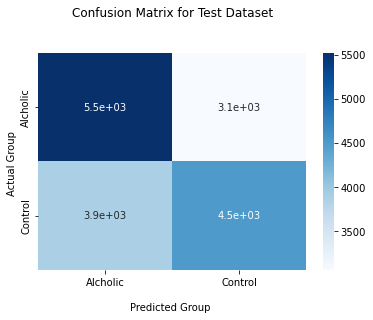

***** Test Set *****


In [132]:
evaluvation_M_B(predictionRF, 'Random Forset Classifier')

--- 137.3744511604309 seconds ---
Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.600
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.605
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.612
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.600
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.605
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.614
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.601
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.607
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.614
***** Test Set Results For lr Classifier pca *****
Area Under ROC Curve (ROC AUC): 0.610
Area Under Precision-Recall Curve: 0.591
Accuracy : : 0.574
Test Error : 0.426
[[5501. 3080.]
 [4117. 4275.]]


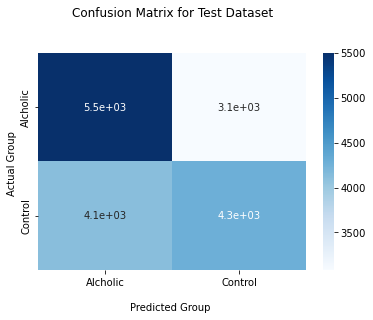

***** Test Set *****


In [133]:
RFModelpca = RandomForestClassifier_pipeline_pca(pca_train_df, 5)
predictionLRpca = RFModelpca.transform(pca_test_df)
CV_data(RFModelpca)
evaluvation_M_B(predictionLRpca, 'lr Classifier pca')

In [134]:
print(RFModel.bestModel.stages[-1])

RandomForestClassificationModel: uid=RandomForestClassifier_31c2ae1b386d, numTrees=128, numClasses=2, numFeatures=262


<h2>SVM</h2>

In [93]:
def LinearSVC_pipeline(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for linearSVC
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        cv_model: CV model trained with traing data given with best choosen paarams
    """
    SV_reg = LinearSVC(featuresCol="std_features", labelCol="label", maxIter=100)
    stage = [SV_reg]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stage)
    param_grid = ParamGridBuilder()\
    .addGrid(SV_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(SV_reg.maxIter , [100, 1000]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                               numFolds=k_fold,
                               collectSubModels=True 
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model


In [106]:
def LinearSVC_pipelinepca(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for linearSVC
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        cv_model: CV model trained with traing data given with best choosen paarams
    """
    SV_reg = LinearSVC(featuresCol="pca_features", labelCol="label", maxIter=100)
    stage = [SV_reg]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stage)
    param_grid = ParamGridBuilder()\
    .addGrid(SV_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(SV_reg.maxIter , [100, 1000]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                               numFolds=k_fold,
                               collectSubModels=True 
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
lsvcModel = LinearSVC_pipeline(trainRDD, 5)

In [97]:
lsvcModel.save(basePath + "/lsvcModelnew")
predictionSVM = lsvcModel.transform(testRDD)

In [98]:
CV_data(lsvcModel)

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.563
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.563
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.562
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.562
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.560
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.560


***** Test Set Results For SVM Classifier *****
Area Under ROC Curve (ROC AUC): 0.554
Area Under Precision-Recall Curve: 0.561
Accuracy : : 0.546
Test Error : 0.454
[[5379. 3202.]
 [4462. 3930.]]


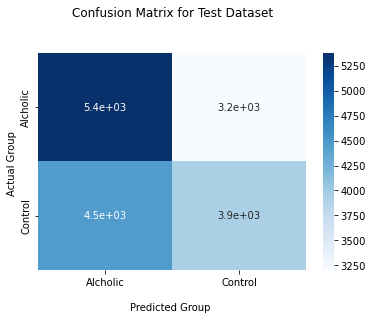

***** Test Set *****


In [99]:
evaluvation_M_B(predictionSVM, 'SVM Classifier')

In [ ]:
lsvcModelpca = LinearSVC_pipelinepca(pca_train_df, 5)
lsvcModelpca.save(basePath + "/lsvcModelpca")


Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.525
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.525
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.521
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.521
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.520
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.520
***** Test Set Results For SVM Classifier pca *****
Area Under ROC Curve (ROC AUC): 0.528
Area Under Precision-Recall Curve: 0.530
Accuracy : : 0.488
Test Error : 0.512
[[5836. 2745.]
 [5672. 2720.]]


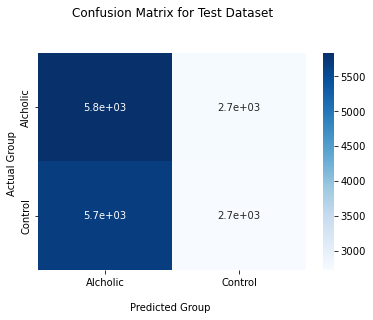

***** Test Set *****


In [108]:
predictionSVMpca = lsvcModelpca.transform(pca_test_df)
CV_data(lsvcModelpca)
evaluvation_M_B(predictionSVMpca, 'SVM Classifier pca')

<h2>LogisticRegression</h2>

In [109]:
def logistic_regression_pipeline_pca(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for logestic Regression
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        cv_model: CV model trained with traing data given with best choosen paarams
    """
    log_reg = LogisticRegression(featuresCol="pca_features", labelCol="label", maxIter=100)
    stage = [log_reg]


    pipeline = Pipeline(stages=stage)
    param_grid = ParamGridBuilder()\
    .addGrid(log_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True 
                               )

    cv_model = cross_val.fit(train)

    return cv_model


<h6>ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.')</h6>

In [110]:
def logistic_regression_pipeline(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for logestic Regression
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        cv_model: CV model trained with traing data given with best choosen paarams
    """
    log_reg = LogisticRegression(featuresCol="std_features", labelCol="label", maxIter=100)
    stage = [log_reg]


    pipeline = Pipeline(stages=stage)
    param_grid = ParamGridBuilder()\
    .addGrid(log_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True 
                               )

    cv_model = cross_val.fit(train)

    return cv_model


In [111]:
lrModel = logistic_regression_pipeline(trainRDD, 5)
lrModel.save(basePath + "/lrModelnew")

In [112]:
CV_data(lrModel)

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.560
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.560
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.560
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.561
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.547
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.500
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.561
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.500
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.500


In [113]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(lrModel.bestModel.stages[-1]._java_obj.getRegParam(), 
             lrModel.bestModel.stages[-1]._java_obj.getElasticNetParam(),
             )
      )
print(lrModel.bestModel.stages[-1])

Best model according to k-fold cross validation: lambda=[0.050]; alfa=[0.000]
LogisticRegressionModel: uid=LogisticRegression_fbbfc8110146, numClasses=2, numFeatures=262


In [114]:
# `bestModel` is the best resulting model according to k-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = lrModel.bestModel.stages[-1].summary
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result.areaUnderROC))
print("***** Training Set *****")

***** Training Set *****
Area Under ROC Curve (ROC AUC): 0.583
***** Training Set *****


***** Test Set Results For logestic Regression Classifier *****
Area Under ROC Curve (ROC AUC): 0.553
Area Under Precision-Recall Curve: 0.560
Accuracy : : 0.545
Test Error : 0.455
[[5212. 3369.]
 [4323. 4069.]]


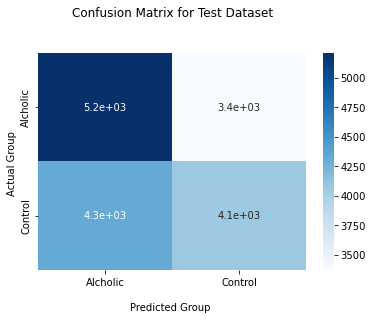

***** Test Set *****


In [115]:
predictionsLG = lrModel.transform(testRDD)
evaluvation_M_B(predictionsLG, 'logestic Regression Classifier')

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.517
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.517
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.517
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.518
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.500
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.500
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.518
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.500
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.500
***** Test Set Results For lr Classifier pca *****
Area Under ROC Curve (ROC AUC): 0.518
Area Under Precision-Recall Curve: 0.524
Accuracy : : 0.501
Test Error : 0.499
[[5795. 2786.]
 [5461. 2931.]]


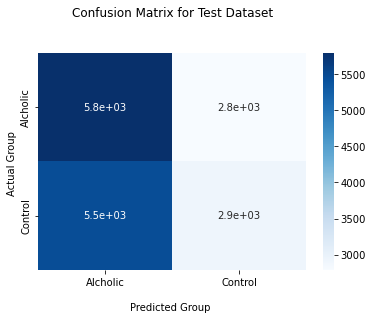

***** Test Set *****


In [116]:
lrModelpca = logistic_regression_pipeline_pca(pca_train_df, 5)
lrModelpca.save(basePath + "/lrModelpca")
predictionLRpca = lrModelpca.transform(pca_test_df)
CV_data(lrModelpca)
evaluvation_M_B(predictionLRpca, 'lr Classifier pca')

In [126]:
def gbdt_pipeline_pca(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for gradient boosting descision tree
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        cv_model: CV model trained with traing data given with best choosen paarams
    """
    gbdt = GBTClassifier(featuresCol="pca_features", labelCol="label") 
    stage = [gbdt]
    pipeline = Pipeline(stages=stage)
    param_grid = ParamGridBuilder()\
    .addGrid(gbdt.maxDepth, [5, 8]) \
    .addGrid(gbdt.maxIter, [50, 100, 120]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    cv_model = cross_val.fit(train)

    return cv_model


In [123]:
def gbdt_pipeline(train, k_fold=5):
    """
    summary: a pipleline will be trained using cross validation for gradient boosting descision tree
    
    params:
        train: trained tranformed vectories data
        k_fold: the number of folds used in CV
    returns:
        cv_model: CV model trained with traing data given with best choosen paarams
    """
    gbdt = GBTClassifier(featuresCol="std_features", labelCol="label") 
    stage = [gbdt]
    pipeline = Pipeline(stages=stage)
    param_grid = ParamGridBuilder()\
    .addGrid(gbdt.maxDepth, [5, 8]) \
    .addGrid(gbdt.maxIter, [50, 100, 120]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    cv_model = cross_val.fit(train)

    return cv_model


Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.655
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.659
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.660
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.638
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.644
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.646
***** Test Set Results For GBT Classifier *****
Area Under ROC Curve (ROC AUC): 0.662
Area Under Precision-Recall Curve: 0.652
Accuracy : : 0.615
Test Error : 0.385
[[5749. 2832.]
 [3678. 4714.]]


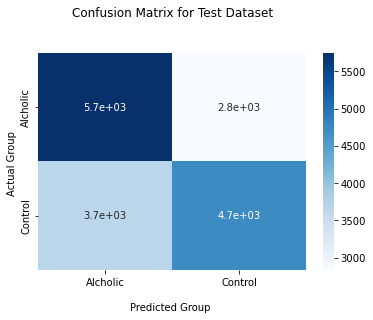

***** Test Set *****


In [124]:
cv_model = gbdt_pipeline(trainRDD,5)
test_predictions = cv_model.transform(testRDD)
CV_data(cv_model)
evaluvation_M_B(test_predictions, 'GBT Classifier')

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.626
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.623
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.621
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.603
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.601
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.601
***** Test Set Results For GBT Classifier *****
Area Under ROC Curve (ROC AUC): 0.630
Area Under Precision-Recall Curve: 0.612
Accuracy : : 0.589
Test Error : 0.411
[[5608. 2973.]
 [3970. 4422.]]


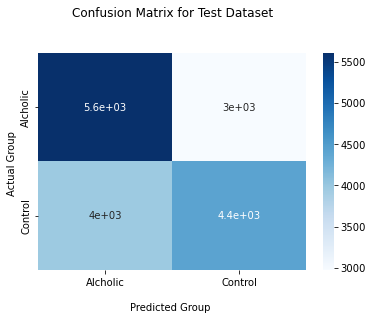

***** Test Set *****


In [127]:
cv_model = gbdt_pipeline_pca(pca_train_df,5)
test_predictions = cv_model.transform(pca_test_df)
CV_data(cv_model)
evaluvation_M_B(test_predictions, 'GBT Classifier')